In [1]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
from google.colab import drive

Using TensorFlow backend.


In [2]:

drive.mount('/content/drive')
#!mkdir  /content/drive/My\ Drive/EIP3Phase2
!ls /content/drive/My\ Drive/EIP3Phase2
!cd  /content/drive/My\ Drive/EIP3Phase2

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
saved_models  session1_1.hdf5  Session1_1.ipynb


In [3]:
# Prepare model model saving directory.
import os
save_dir = os.path.join(os.getcwd(), 'drive/My Drive/EIP3Phase2/saved_models')
model_name = 'cifar10_session1_1.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
!ls /content/drive/My\ Drive/EIP3Phase2

saved_models  session1_1.hdf5  Session1_1.ipynb


In [4]:

# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10
firsttime = 0

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


170500096/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
# Building the model

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)



# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)



Using TensorFlow backend.
W0716 13:29:57.901824 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 13:29:57.915644 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 13:29:57.919294 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0716 13:29:57.946835 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session inste

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


W0716 13:29:58.617094 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0716 13:30:00.325214 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0716 13:30:00.361258 139702019291008 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [0]:

# Fit the model on the batches generated by datagen.flow().
if (firsttime == 1):
    print("Training is starting.")
    train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
    STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
    print(STEP_SIZE_TRAIN)
    model.fit_generator(train_generator,
                        steps_per_epoch = STEP_SIZE_TRAIN,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=0, workers=4,
                        callbacks=callbacks)

    print("Training is complete. Saving the model")

    model.save('/content/drive/My Drive/EIP3Phase2/session1_1.hdf5')
    
else:
    model = load_model('/content/drive/My Drive/EIP3Phase2/session1_1.hdf5')
    

Training is starting.
1562
Learning rate:  0.001

Epoch 00001: val_acc improved from -inf to 0.64920, saving model to /content/drive/My Drive/EIP3Phase2/saved_models/cifar10_session1_1.h5
Learning rate:  0.001

Epoch 00002: val_acc improved from 0.64920 to 0.66320, saving model to /content/drive/My Drive/EIP3Phase2/saved_models/cifar10_session1_1.h5
Learning rate:  0.001

Epoch 00003: val_acc improved from 0.66320 to 0.68540, saving model to /content/drive/My Drive/EIP3Phase2/saved_models/cifar10_session1_1.h5
Learning rate:  0.001

Epoch 00004: val_acc improved from 0.68540 to 0.71340, saving model to /content/drive/My Drive/EIP3Phase2/saved_models/cifar10_session1_1.h5
Learning rate:  0.001

Epoch 00005: val_acc improved from 0.71340 to 0.75510, saving model to /content/drive/My Drive/EIP3Phase2/saved_models/cifar10_session1_1.h5
Learning rate:  0.001

Epoch 00006: val_acc did not improve from 0.75510
Learning rate:  0.001

Epoch 00007: val_acc did not improve from 0.75510
Learning r

In [6]:
from keras.models import load_model

if (firsttime == 0):
   model = load_model('/content/drive/My Drive/EIP3Phase2/session1_1.hdf5')
    
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

W0717 14:14:12.704189 139664169564032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 14:14:12.748907 139664169564032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0717 14:14:12.795501 139664169564032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 14:14:12.796411 139664169564032 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0717 14:14:12.79915

10000/10000 [==============================] - 5s 548us/step
Test loss: 0.4598053684234619
Test accuracy: 0.9125


W0717 15:14:37.956156 139664169564032 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 15:14:37.974911 139664169564032 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 15:14:37.989268 139664169564032 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 15:14:38.001689 139664169564032 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 15:14:38.015681 139664169564032 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 15:14:38.030650 139664169564032 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0717 15:14:38.045651 139664

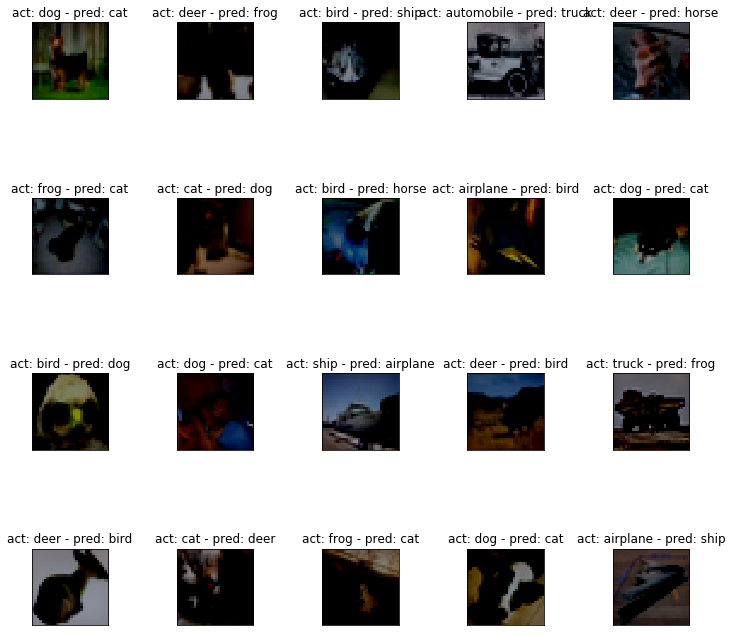

In [28]:
import numpy
from numpy import argmax
import matplotlib.pyplot as plt

predicted = model.predict(x_test)
result = numpy.absolute(y_test-predicted)


#test_generator = datagen.flow(x_test, y_test, batch_size=batch_size)
#print(test_generator.n)
#print(y_test[0])
#print(predicted[0])

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

count=0
num_samples=20
fig = plt.figure(figsize=(10,10))

#print("Val-img-idx   predicted-label  actual-label")
for i in range(10000):
  j = argmax(predicted[i])
  k = argmax(y_test[i])
  if (j != k):
    #print(predicted[i])
    #print(y_test[i])
    #print(i, j, k)
    ax = fig.add_subplot(4, 5, 1 + count, xticks=[], yticks=[])
    #idx = np.where(y_test[:]==k)[0]
    #features_idx = x_test[idx,::]
    #img_num = np.random.randint(features_idx.shape[0])
    #print (idx)
    img_num=i
    #im = features_idx[img_num]
    im = x_test[img_num,::]
    imtitle="act: " + class_names[k]+ " - "+ "pred: "+ class_names[j]
    ax.set_title(imtitle)
    plt.imshow(im)
    count = count + 1
    if (count > (num_samples - 1)):
      break
      
l  = 0.125  # the left side of the subplots of the figure
r = 0.9    # the right side of the subplots of the figure
b = 0.1   # the bottom of the subplots of the figure
t = 0.9      # the top of the subplots of the figure
w = 0.2   # the amount of width reserved for blank space between subplots
h = 0.2   # the amount of height reserved for white space between subplots 
#fig.subplots_adjust(left=l, bottom=b, right=r, top=t, wspace=w, hspace=h)
fig.tight_layout()
plt.show()